<a href="https://colab.research.google.com/github/Faskill/MLOps-Article-Classification/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
# Extracting projects
PROJECTS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(PROJECTS_URL)
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [90]:
# Extracting tags
TAGS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags = pd.read_csv(TAGS_URL)
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [91]:
df = pd.merge(projects, tags, on="id", how = "outer")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [92]:
df = df[df.tag.notnull()]

df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [93]:
# Saving data locally
df.to_csv("labeled_projects.csv", index=False)

In [94]:
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
mlops                           79
reinforcement-learning          56
graph-learning                  45
time-series                     31
Name: tag, dtype: int64

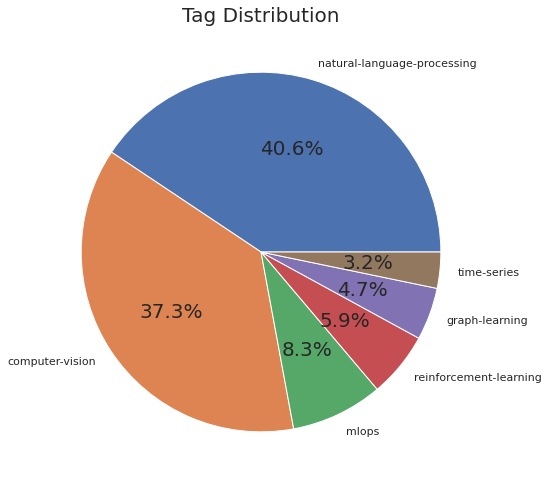

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

vc = df.tag.value_counts()
plt.pie(vc, labels = vc.index,autopct='%1.1f%%')
plt.title('Tag Distribution')
plt.show()

In [96]:
df['title_length'] = df['title'].apply(len)
df['desc_length'] = df['description'].apply(len)

df.head()

,id,created_on,title,description,tag,title_length,desc_length
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89


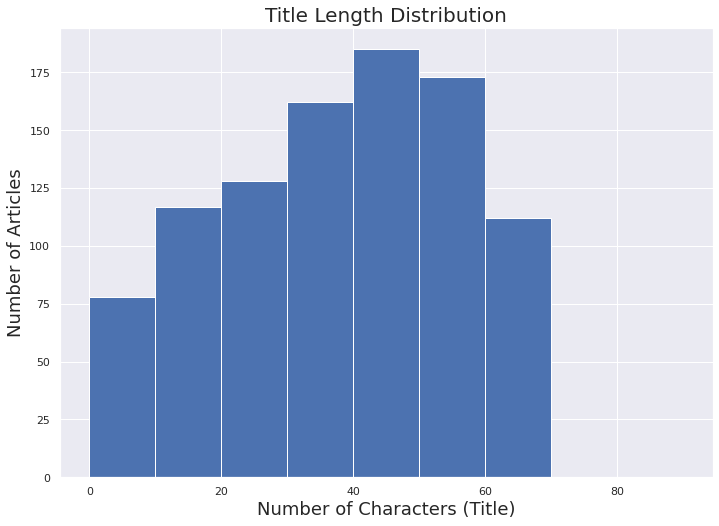

In [97]:
plt.hist(df['title_length'], bins = range(0,100,10))
plt.title('Title Length Distribution')
plt.xlabel('Number of Characters (Title)')
plt.ylabel('Number of Articles')
plt.show()

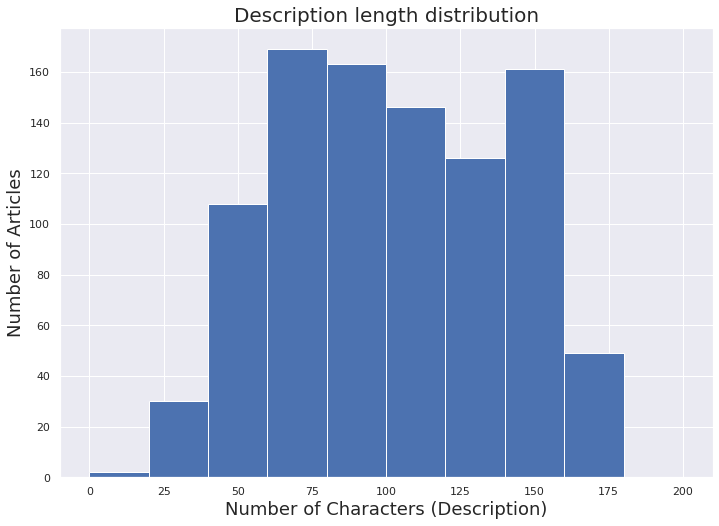

In [98]:
plt.hist(df['desc_length'], bins = range(0,220,20))
plt.title('Description length distribution')
plt.xlabel('Number of Characters (Description)')
plt.ylabel('Number of Articles')
plt.show()

In [99]:
#Let's investigate the outliers with a description below 25 characters
df[df.desc_length < 25]

,id,created_on,title,description,tag,title_length,desc_length
29,108,2020-03-21 23:17:38,Tuned ALBERT (ensemble model),Top 6 in Squad 2.0,natural-language-processing,29,18
341,880,2020-05-16 11:50:31,How Deep Is Your Love For Transfer Learning In...,A review of NLP research,natural-language-processing,51,24
536,1480,2020-06-16 23:06:13,A Guide to Natural Language Processing With Al...,basics of using AllenNLP,natural-language-processing,52,24
695,1856,2020-07-14 03:21:00,DeepDream Video Style Transfer,DeepDream on Video,computer-vision,30,18
737,1934,2020-07-21 01:47:01,Graphein,Protein Graph Library,graph-learning,8,21
747,1954,2020-07-24 06:43:59,Azure ML,MLOps using Azure ML.,mlops,8,21
942,2417,2020-10-02 09:44:25,Parallelizing Prophet Cross-Validation with Dask,Applied Example w/ Code,time-series,48,23


In [100]:
df['tag'].unique()

array(['computer-vision', 'graph-learning', 'reinforcement-learning',
       'natural-language-processing', 'mlops', 'time-series'],
      dtype=object)

In [101]:
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets

# Most frequent tokens for each tag
@widgets.interact(tag=df['tag'].unique())
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

In [102]:
#Feature engineering

df['text'] = df['title'] + ' ' + df['description']

df.head()

,id,created_on,title,description,tag,title_length,desc_length,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89,Diffusion to Vector Reference implementation o...


In [103]:
!pip install nltk==3.7 -q
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [104]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:

def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower:
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [106]:
# Apply to dataframe
df['cleaned_text'] = df.text.apply(clean_text, lower=True, stem=False)
print (f"{df.text.values[0]}\n{df.cleaned_text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [107]:
import json
#List of accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

#Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [108]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [109]:

# Replace this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [110]:
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                           87
mlops                           79
graph-learning                  45
Name: tag, dtype: int64

In [111]:
#Not enough data to identify the graph learning topics (we set a threshold at 75)
#We will join this category with our "other" category
def filter_tags(tag, exclude=[]):
  if tag in exclude:
    tag = None
  return tag

df.tag = df.tag.apply(filter_tags, exclude = ['graph-learning'])

df.tag = df.tag.fillna("other")
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                          132
mlops                           79
Name: tag, dtype: int64

In [112]:
import numpy as np
import random


# Get data
X = df.cleaned_text.to_numpy()
y = df.tag

In [113]:
#Defining custom LabelEncoder (alternative would be to use sklearn's implementation)

class LabelEncoder(object):
    """Encode labels into unique indices"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [114]:

# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

num_classes

4

In [115]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [116]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [117]:
#Testing encoder

# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [118]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))

['computer-vision', 'mlops', 'mlops']

In [119]:

# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [120]:
from sklearn.model_selection import train_test_split

# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [121]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [122]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)


print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [123]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}


# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [124]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))
    
    
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


We can see that our test/train split are quite balanced.
Let's calculate the standard deviation :

In [125]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

In [126]:
#Example of code for multi-label classification
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [127]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,albumentations fast image augmentation library...,computer-vision
1,visual object tracking using adaptive correlat...,computer-vision
2,controlling text generation plug play language...,natural-language-processing
3,haystack neural question answering scale trans...,natural-language-processing
4,question answering fine tuned bert mean bert a...,natural-language-processing


In [128]:
#Data Augmentation :

!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.8 -q

import nlpaug.augmenter.word as naw

In [129]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")
text = "Conditional image generation using Variational Autoencoders and GANs."

In [130]:
# Substitutions
substitution.augment(text)

'dynamic probability mapping using variational filters and gans.'

Substitutions do not seem like a very good idea because they remove keywords like GAN here.


In [131]:
# Insertions
insertion.augment(text)

'robust conditional nonlinear image generation optimization using concurrent variational autoencoders and gans.'

The problem is now that there is a risk that keywords will get inserted into our text samples.

In [132]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [133]:
flattened_aliases

{'computer vision': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'mlops': ['production'],
 'production': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing']}

In [134]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [135]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [136]:
#Using the inflect package to add plurals to our aliases

!pip install inflect
import inflect

p = inflect.engine()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
inflected_aliases = {}

for _tag, _alias in flattened_aliases.items():
    inflected_aliases[_tag] = _alias
    inflected_aliases[p.plural(_tag)] = _alias

inflected_aliases

{'computer vision': ['cv', 'vision'],
 'computer visions': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'cvs': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'visions': ['cv', 'computer vision'],
 'mlops': ['production'],
 'mlop': ['production'],
 'production': ['mlops'],
 'productions': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'natural language processings': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlps': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing'],
 'nlprocs': ['nlp', 'natural language processing']}

In [138]:
#Using snorkel's transformations to apply this modification to our data

from snorkel.augmentation import transformation_function

@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(inflected_aliases[tag])}{x.text[match.end():]}"
    return x

In [139]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning natural language processing tasks


In [140]:

# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate vision apply jobs using nlp
autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc


In [141]:
# Defining an Augmentation Policy
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier


# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:02<00:00, 273.51it/s]


,text,tag
0,albumentations fast image augmentation library...,computer-vision
1,visual object tracking using adaptive correlat...,computer-vision
2,controlling text generation plug play language...,natural-language-processing
3,haystack neural question answering scale trans...,natural-language-processing
4,question answering fine tuned bert mean bert a...,natural-language-processing


In [142]:
len(train_df), len(train_df_augmented)

(668, 893)

In [143]:
#This was an example of Data augmentation, but we will not use this in the rest of the project

In [144]:
# Modeling, first we will implement a random algorithm
from collections import Counter
import random

def set_seeds(seed=42):
  #Set seeds for reproducibility
  np.random.seed(seed)
  random.seed(seed)

def preprocess(df, lower, stem, min_freq):
  df["text"] = df.title + " " + df.description # Feature engineering
  df.text = df.text.apply(clean_text, lower=lower, stem = stem) #Clean text

  #Replace OOS tags with 'other'
  oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
  df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

  #Replace tags below min_freq with 'other'
  tags = Counter(df.tag.values)
  tags_above_freq = Counter(tag for tag in tags.elements()
                            if (tags[tag] >= min_freq))
  
  df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
  df.tag = df.tag.fillna("other")

  return df


In [145]:
def create_splits(X, y, train_size = 0.7):
  """Generate balanced data splits"""
  X_train, X_, y_train, y_ = train_test_split(
      X, y, train_size=train_size, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(
      X_, y_, train_size=0.5, stratify=y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [146]:
#Not necessary but could be needed with a larger database
#df = df.sample(frac=1).reset_index(drop=True) #Shuffle
#df = df[:num samples]
from sklearn.metrics import precision_recall_fscore_support

In [147]:
#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Label encoder verification

print(label_encoder)
print(label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [148]:
#Generating random predictions
y_pred = np.random.randint(low=0, high = len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred[0:5])

(144,)
[2 2 1 3 3]


In [149]:
#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.2844744487889649, 'recall': 0.22916666666666666, 'f1': 0.24552884283001275}


In [150]:
#Using the train split to apply realistic class probabilities

#Class frequencies 
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
p

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]

In [151]:
#Generating weighted predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.3294211281499417, 'recall': 0.3194444444444444, 'f1': 0.3239553132352485}


In [152]:
#Rule based methodology 

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [153]:
#If a token matches an alias, then add the corresponding tag class
def get_tag(text, aliases_by_tag):
  for tag, aliases in aliases_by_tag.items():
    if replace_dash(tag) in text:
      return tag
    for alias in aliases:
      if alias in text:
        return tag
  return None

In [154]:
#Sample
text = "An excellent model for the best NLP models"

get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag)

'natural-language-processing'

In [155]:
#Prediction
tags = []
for text in X_test:
  tag = get_tag(text, aliases_by_tag=aliases_by_tag)
  tags.append(tag)

#Encoding labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.8611111111111112, 'recall': 0.1597222222222222, 'f1': 0.2600750175139683}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


In [156]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag))

None


In [157]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Saving X_test to compare with later
X_test_raw = X_test

In [158]:
#TF-IDF
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7)) #Char n-grams 2-7
print(X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

print(X_train.shape)

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
(668, 98496)


In [159]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i,count in enumerate(counts)}
print(f"class counts: {counts}, \n class weights: {class_weights}")

class counts: [249  55 272  92], 
 class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


In [160]:
# Data imbalance
!pip install imbalanced-learn==0.8.1 -q
from imblearn.over_sampling import RandomOverSampler

In [161]:

# Oversampling (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [162]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


In [163]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

# Initializing model
#We're using a SGD Classifier with log loss
#This is very similar to a Log Regression with SGD

model = SGDClassifier(
loss="log", penalty="l2", alpha=1e-4, max_iter=100,
learning_rate="constant", eta0=1e-1, power_t=0.1,
warm_start=True)

In [164]:
# Model training
num_epochs = 100
for epoch in range(num_epochs+1):
  # Training
  model.fit(X_over, y_over)
  # Evaluation
  train_loss = log_loss(y_train, model.predict_proba(X_train))
  val_loss = log_loss(y_val, model.predict_proba(X_val))
  if not epoch%10:
    print(
      f"Epoch: {epoch:02d} | "
      f"train_loss: {train_loss:.5f}, "
      f"val_loss: {val_loss:.5f}"
    )

Epoch: 00 | train_loss: 0.20354, val_loss: 0.44303
Epoch: 10 | train_loss: 0.15648, val_loss: 0.41225
Epoch: 20 | train_loss: 0.14875, val_loss: 0.40816
Epoch: 30 | train_loss: 0.14596, val_loss: 0.40702
Epoch: 40 | train_loss: 0.14440, val_loss: 0.40636
Epoch: 50 | train_loss: 0.14313, val_loss: 0.40581
Epoch: 60 | train_loss: 0.14214, val_loss: 0.40540
Epoch: 70 | train_loss: 0.14134, val_loss: 0.40513
Epoch: 80 | train_loss: 0.14079, val_loss: 0.40494
Epoch: 90 | train_loss: 0.14020, val_loss: 0.40474
Epoch: 100 | train_loss: 0.13978, val_loss: 0.40455


In [165]:
# Evaluation
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8764647844565878,
  "recall": 0.875,
  "f1": 0.8737886461377173
}


In [166]:
# Testing (with tokens not similar to training data)
text = "Using text classification to predict the sentiment of Twitter posts"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [167]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.07018529397337082,
 'mlops': 0.004552824383735391,
 'natural-language-processing': 0.8949149611229926,
 'other': 0.030346920519901184}

In [168]:
# Second test
text = "Using GAN to predict model behavior"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [169]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.36066013050841494,
 'mlops': 0.045477797277782596,
 'natural-language-processing': 0.4430094358866647,
 'other': 0.15085263632713797}

It predicts nlp but the utterance clearly belonged to the "other" category. We will create a custom predict function to avoid this problem.

The custom predict function will take as a threshold the first quantile softmax score for the correct class.

We use the validation split to **avoid data leakage.**

In [170]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)],
q=0.25) # Q1
threshold

0.6841094257700038

It would be interesting to look at **class thresholds**, because those may significantly differ for each class.

In [171]:
class_thresholds = {}
for c in range(len(label_encoder.classes)):
  class_thresholds[c] = np.quantile(
      [y_prob[i][c] for i in np.where(y_pred==c)[0]],
      q=0.25)
class_thresholds

{0: 0.6991101748903702,
 1: 0.6438804248079768,
 2: 0.6964953391485422,
 3: 0.5424208623945845}

In [172]:
class_thresholds[np.argmax(y_prob[1])]

0.6991101748903702

In [173]:
# Custom predict function
def custom_predict(y_prob, class_thresholds, index):
  """Custom predict function that defaults
  to an index if conditions are not met."""
  y_pred = [np.argmax(p) if max(p) > class_thresholds[np.argmax(p)] else index for p in
  y_prob]
  return np.array(y_pred)

In [174]:
def predict_tag(texts):
  y_prob = model.predict_proba(vectorizer.transform(texts))
  other_index = label_encoder.class_to_index["other"]
  y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
  index=other_index)
  return label_encoder.decode(y_pred)

In [175]:
# Testing (with tokens not similar to training data)
text = "Using GAN to predict model behavior"
predict_tag(texts=[text])

['other']

In [176]:
# Evaluation
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [177]:
#Metrics
metrics = {"overall": {}, "class": {}}

# Overall metrics
from sklearn.metrics import precision_recall_fscore_support

overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9032828282828282,
    "recall": 0.75,
    "f1": 0.7852151881854853,
    "num_samples": 144.0
}


In [178]:
# Fine-grained class specific metrics
from collections import OrderedDict

class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }


# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 1.0,
    "recall": 0.7413793103448276,
    "f1": 0.8514851485148515,
    "num_samples": 58.0
  }
]
[
  "mlops",
  {
    "precision": 0.9,
    "recall": 0.75,
    "f1": 0.8181818181818182,
    "num_samples": 12.0
  }
]
[
  "computer-vision",
  {
    "precision": 1.0,
    "recall": 0.6666666666666666,
    "f1": 0.8,
    "num_samples": 54.0
  }
]
[
  "other",
  {
    "precision": 0.36363636363636365,
    "recall": 1.0,
    "f1": 0.5333333333333333,
    "num_samples": 20.0
  }
]


In [181]:
# TP, FP, FN samples for mlops
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [182]:
print (tp)
print (fp)
print (fn)

[0, 5, 47, 52, 96, 111, 123, 129, 141]
[114]
[38, 130, 136]


In [183]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"  {X_test_raw[index]}")
            print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")


=== True positives ===
  pytest pytest framework makes easy write small tests yet scales support complex functional testing
    true: mlops
    pred: mlops

  test machine learning code systems minimal examples testing machine learning correct implementation expected learned behaviour model performance
    true: mlops
    pred: mlops

  continuous machine learning cml cml helps organize mlops infrastructure top traditional software engineering stack instead creating separate ai platforms
    true: mlops
    pred: mlops


=== False positives ===
  paint machine learning web app allows create landscape painting style bob ross using deep learning model served using spell model server
    true: computer-vision
    pred: mlops


=== False negatives ===
  hidden technical debt machine learning systems using software engineering framework technical debt find common incur massive ongoing maintenance costs real world ml systems
    true: mlops
    pred: other

  docker help become effective da

In [184]:
# Confident Learning
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

(144,)
(144, 4)


In [185]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i],
                               "true": label_encoder.index_to_class[y_test[i]],
                               "pred": label_encoder.index_to_class[y_pred[i]],
                               "prob": prob})

low_confidence[0:5]

[{'text': 'neptune ai lightweight experiment management tool fits workflow',
  'true': 'mlops',
  'pred': 'other',
  'prob': 0.3806817845628073}]

In [186]:
# Using cleanlab to identify noisy labels
!pip install cleanlab==1.0.1 -q
import cleanlab
from cleanlab.pruning import get_noise_indices

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 KB 8.2 MB/s eta 0:00:00


In [199]:
#Applying to test set
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)


# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test,
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)


num_samples = 20
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

text: module 2 convolutional neural networks cs231n lecture 5 move fully connected neural networks convolutional neural networks
true: computer-vision
pred: other

text: goturn pytorch pytorch implementation learning track 100 fps deep regression networks
true: computer-vision
pred: other



In [197]:
label_error_indices

array([], dtype=int64)

In [200]:
#Defining slicing functions with snorkel
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)


@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [201]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 8932.63it/s]


,text,tag
110,understanding convolutional neural networks nl...,natural-language-processing


In [203]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 21607.75it/s]


,text,tag
33,chakin simple downloader pre trained word vectors,natural-language-processing
73,tsaug python package time series augmentation,other
76,nlpaug data augmentation nlp,natural-language-processing
79,texthero text preprocessing representation vis...,natural-language-processing
111,machine learning production pipeline project f...,mlops


In [204]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 144/144 [00:00<00:00, 8441.01it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [205]:
#Calculating metrics for our slices
#We choose not to use the snorkel.analysis.Scorer function so that we can adapt to multilabel senarios

metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_cnn": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 1
  },
  "short_text": {
    "precision": 0.4,
    "recall": 0.4,
    "f1": 0.4000000000000001,
    "num_samples": 5
  }
}


In [208]:
#Interpretability
#We can use LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance

!pip install lime==0.2.0.1 -q
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

#Creating a piepeline
pipe = make_pipeline(vectorizer, model)

# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [211]:
#Beahavioral testing i.e. sanity check

#Invariance :
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'natural-language-processing']

In [212]:
# Directional expectations 
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'computer-vision']

In [213]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'mlops']